<a href="https://colab.research.google.com/github/achaudhury7378/IE-643-Implementation/blob/main/IE643_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing The Libraries

In [ ]:
import argparse
import copy
import os
import sys
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import seaborn as sns
import torch.nn.init as init
import pickle

# Custom Libraries
# import utils

In [ ]:
#ANCHOR Print table of zeros and non-zeros count
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return (round((nonzero/total)*100,1))

def original_initialization(mask_temp, initial_state_dict):
    global model
    
    step = 0
    for name, param in model.named_parameters(): 
        if "weight" in name: 
            weight_dev = param.device
            param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
            step = step + 1
        if "bias" in name:
            param.data = initial_state_dict[name]
    step = 0

        


#ANCHOR Checks of the directory exist and if not, creates a new directory
def checkdir(directory):
            if not os.path.exists(directory):
                os.makedirs(directory)

#FIXME 
def plot_train_test_stats(stats,
                          epoch_num,
                          key1='train',
                          key2='test',
                          key1_label=None,
                          key2_label=None,
                          xlabel=None,
                          ylabel=None,
                          title=None,
                          yscale=None,
                          ylim_bottom=None,
                          ylim_top=None,
                          savefig=None,
                          sns_style='darkgrid'
                          ):

    assert len(stats[key1]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key1, len(stats[key1]), epoch_num)
    assert len(stats[key2]) == epoch_num, "len(stats['{}'])({}) != epoch_num({})".format(key2, len(stats[key2]), epoch_num)

    plt.clf()
    sns.set_style(sns_style)
    x_ticks = np.arange(epoch_num)

    plt.plot(x_ticks, stats[key1], label=key1_label)
    plt.plot(x_ticks, stats[key2], label=key2_label)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    if title is not None:
        plt.title(title)

    if yscale is not None:
        plt.yscale(yscale)

    if ylim_bottom is not None:
        plt.ylim(bottom=ylim_bottom)
    if ylim_top is not None:
        plt.ylim(top=ylim_top)

    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fancybox=True)

    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight')
    else:
        plt.show()

# Describing the Architectures

In [ ]:
class fc1(nn.Module):

    def __init__(self, num_classes=10):
        super(fc1, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*14*14, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# The Main Procedures

In [ ]:
# Main
writer = SummaryWriter()
def main(args, ITE=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reinit = True if args.prune_type=="reinit" else False

    # Data Loader
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
    if args.dataset == "mnist":
        traindataset = datasets.MNIST('../data', train=True, download=True,transform=transform)
        testdataset = datasets.MNIST('../data', train=False, transform=transform)
        # from archs.mnist import LeNet5, fc1


    train_loader = torch.utils.data.DataLoader(traindataset, batch_size=args.batch_size, shuffle=True, num_workers=0,drop_last=False)
    #train_loader = cycle(train_loader)
    test_loader = torch.utils.data.DataLoader(testdataset, batch_size=args.batch_size, shuffle=False, num_workers=0,drop_last=True)
    
    # Importing Network Architecture
    global model
    if args.arch_type == "fc1":
       model = fc1().to(device)
    elif args.arch_type == "lenet5":
        model = LeNet5().to(device)


    # Weight Initialization
    model.apply(weight_init)

    # Copying and Saving Initial State
    initial_state_dict = copy.deepcopy(model.state_dict())
    checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
    torch.save(model, f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/initial_state_dict_{args.prune_type}.pth.tar")

    # Making Initial Mask
    make_mask(model)

    # Optimizer and Loss
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss() # Default was F.nll_loss

    # Layer Looper
    for name, param in model.named_parameters():
        print(name, param.size())

    # Pruning
    # NOTE First Pruning Iteration is of No Compression
    bestacc = 0.0
    best_accuracy = 0
    ITERATION = args.prune_iterations
    comp = np.zeros(ITERATION,float)
    bestacc = np.zeros(ITERATION,float)
    step = 0
    all_loss = np.zeros(args.end_iter,float)
    all_accuracy = np.zeros(args.end_iter,float)


    for _ite in range(args.start_iter, ITERATION):
        if not _ite == 0:
            prune_by_percentile(args.prune_percent, resample=resample, reinit=reinit)
            if reinit:
                model.apply(weight_init)
                #if args.arch_type == "fc1":
                #    model = fc1.fc1().to(device)
                #elif args.arch_type == "lenet5":
                #    model = LeNet5.LeNet5().to(device)
                #elif args.arch_type == "alexnet":
                #    model = AlexNet.AlexNet().to(device)
                #elif args.arch_type == "vgg16":
                #    model = vgg.vgg16().to(device)  
                #elif args.arch_type == "resnet18":
                #    model = resnet.resnet18().to(device)   
                #elif args.arch_type == "densenet121":
                #    model = densenet.densenet121().to(device)   
                #else:
                #    print("\nWrong Model choice\n")
                #    exit()
                step = 0
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        weight_dev = param.device
                        param.data = torch.from_numpy(param.data.cpu().numpy() * mask[step]).to(weight_dev)
                        step = step + 1
                step = 0
            else:
                original_initialization(mask, initial_state_dict)
            optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)
        print(f"\n--- Pruning Level [{ITE}:{_ite}/{ITERATION}]: ---")

        # Print the table of Nonzeros in each layer
        comp1 = print_nonzeros(model)
        comp[_ite] = comp1
        pbar = tqdm(range(args.end_iter))

        for iter_ in pbar:

            # Frequency for Testing
            if iter_ % args.valid_freq == 0:
                accuracy = test(model, test_loader, criterion)

                # Save Weights
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    checkdir(f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/")
                    torch.save(model,f"{os.getcwd()}/saves/{args.arch_type}/{args.dataset}/{_ite}_model_{args.prune_type}.pth.tar")

            # Training
            loss = train(model, train_loader, optimizer, criterion)
            all_loss[iter_] = loss
            all_accuracy[iter_] = accuracy
            
            # Frequency for Printing Accuracy and Loss
            if iter_ % args.print_freq == 0:
                pbar.set_description(
                    f'Train Epoch: {iter_}/{args.end_iter} Loss: {loss:.6f} Accuracy: {accuracy:.2f}% Best Accuracy: {best_accuracy:.2f}%')       

        writer.add_scalar('Accuracy/test', best_accuracy, comp1)
        bestacc[_ite]=best_accuracy

        # Plotting Loss (Training), Accuracy (Testing), Iteration Curve
        #NOTE Loss is computed for every iteration while Accuracy is computed only for every {args.valid_freq} iterations. Therefore Accuracy saved is constant during the uncomputed iterations.
        #NOTE Normalized the accuracy to [0,100] for ease of plotting.
        plt.plot(np.arange(1,(args.end_iter)+1), 100*(all_loss - np.min(all_loss))/np.ptp(all_loss).astype(float), c="blue", label="Loss") 
        plt.plot(np.arange(1,(args.end_iter)+1), all_accuracy, c="red", label="Accuracy") 
        Loss.append(100*(all_loss - np.min(all_loss))/np.ptp(all_loss))
        Accuracies.append(all_accuracy)
        Iters.append(args.end_iter)
        Comps.append(comp1)
        plt.title(f"Loss Vs Accuracy Vs Iterations ({args.dataset},{args.arch_type})") 
        plt.xlabel("Iterations") 
        plt.ylabel("Loss and Accuracy") 
        plt.legend() 
        plt.grid(color="gray") 
        checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
        plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_LossVsAccuracy_{comp1}.png", dpi=1200) 
        plt.close()

        # Dump Plot values
        # utils.checkdir(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/")
        # all_loss.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_all_loss_{comp1}.dat")
        # all_accuracy.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_all_accuracy_{comp1}.dat")
        
        # Dumping mask
        # utils.checkdir(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/")
        # with open(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_mask_{comp1}.pkl", 'wb') as fp:
        #     pickle.dump(mask, fp)
        
        # Making variables into 0
        best_accuracy = 0
        all_loss = np.zeros(args.end_iter,float)
        all_accuracy = np.zeros(args.end_iter,float)

    # Dumping Values for Plotting
    # utils.checkdir(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/")
    # comp.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_compression.dat")
    # bestacc.dump(f"{os.getcwd()}/dumps/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_bestaccuracy.dat")

    # Plotting 
    a = np.arange(args.prune_iterations)
    plt.plot(a, bestacc, c="blue", label="Winning tickets") 
    plt.title(f"Test Accuracy vs Unpruned Weights Percentage ({args.dataset},{args.arch_type})") 
    plt.xlabel("Unpruned Weights Percentage") 
    plt.ylabel("test accuracy") 
    plt.xticks(a, comp, rotation ="vertical") 
    plt.ylim(0,100)
    plt.legend() 
    plt.grid(color="gray") 
    checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
    plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_AccuracyVsWeights.png", dpi=1200) 
    plt.close() 
    return (a,comp,bestacc)                   
   
# Function for Training
def train(model, train_loader, optimizer, criterion):
    EPS = 1e-6
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (imgs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        #imgs, targets = next(train_loader)
        imgs, targets = imgs.to(device), targets.to(device)
        output = model(imgs)
        train_loss = criterion(output, targets)
        train_loss.backward()

        # Freezing Pruned weights by making their gradients Zero
        for name, p in model.named_parameters():
            if 'weight' in name:
                tensor = p.data.cpu().numpy()
                grad_tensor = p.grad.data.cpu().numpy()
                grad_tensor = np.where(tensor < EPS, 0, grad_tensor)
                p.grad.data = torch.from_numpy(grad_tensor).to(device)
        optimizer.step()
    return train_loss.item()

# Function for Testing
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

# Prune by Percentile module
def prune_by_percentile(percent, resample=False, reinit=False,**kwargs):
        global step
        global mask
        global model

        # Calculate percentile value
        step = 0
        for name, param in model.named_parameters():

            # We do not prune bias term
            if 'weight' in name:
                tensor = param.data.cpu().numpy()
                alive = tensor[np.nonzero(tensor)] # flattened array of nonzero values
                percentile_value = np.percentile(abs(alive), percent)

                # Convert Tensors to numpy and calculate
                weight_dev = param.device
                new_mask = np.where(abs(tensor) < percentile_value, 0, mask[step])
                
                # Apply new weight and mask
                param.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
                mask[step] = new_mask
                step += 1
        step = 0

# Function to make an empty mask of the same size as the model
def make_mask(model):
    global step
    global mask
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            step = step + 1
    mask = [None]* step 
    step = 0
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            tensor = param.data.cpu().numpy()
            mask[step] = np.ones_like(tensor)
            step = step + 1
    step = 0

# def original_initialization(mask_temp, initial_state_dict):
#     global model
    
#     step = 0
#     for name, param in model.named_parameters(): 
#         if "weight" in name: 
#             weight_dev = param.device
#             param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
#             step = step + 1
#         if "bias" in name:
#             param.data = initial_state_dict[name]
#     step = 0

# Function for Initialization
def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)


if __name__=="__main__":
    
    #from gooey import Gooey
    #@Gooey      
    
    # Arguement Parser
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--lr",default= 1.2e-3, type=float, help="Learning rate")
    # parser.add_argument("--batch_size", default=60, type=int)
    # parser.add_argument("--start_iter", default=0, type=int)
    # parser.add_argument("--end_iter", default=100, type=int)
    # parser.add_argument("--print_freq", default=1, type=int)
    # parser.add_argument("--valid_freq", default=1, type=int)
    # parser.add_argument("--resume", action="store_true")
    # parser.add_argument("--prune_type", default="lt", type=str, help="lt | reinit")
    # parser.add_argument("--gpu", default="0", type=str)
    # parser.add_argument("--dataset", default="mnist", type=str, help="mnist | cifar10 | fashionmnist | cifar100")
    # parser.add_argument("--arch_type", default="fc1", type=str, help="fc1 | lenet5 | alexnet | vgg16 | resnet18 | densenet121")
    # parser.add_argument("--prune_percent", default=10, type=int, help="Pruning percent")
    # parser.add_argument("--prune_iterations", default=35, type=int, help="Pruning iterations count")

    class data():
        def __init__(self, lr=1.2e-3,batch_size=60,start_iter=0,end_iter=50,print_freq=10,valid_freq=1,resume=True,prune_type="lt",gpu="0",dataset="mnist",arch_type="lenet5",prune_percent=20,prune_iterations=20):
          self.lr=lr
          self.batch_size=batch_size
          self.start_iter=start_iter
          self.end_iter=end_iter
          self.print_freq=print_freq
          self.valid_freq=valid_freq
          self.resume=resume
          self.prune_type=prune_type
          self.gpu=gpu
          self.dataset=dataset
          self.arch_type=arch_type
          self.prune_percent=prune_percent
          self.prune_iterations=prune_iterations

    args = data()


    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]=args.gpu
    
    
    #FIXME resample
    resample = False
    Loss=[]
    Accuracies=[]
    Iters=[]
    Comps=[]
    # Looping Entire process
    #for i in range(0, 5):
    (a,comp,best_acc)=main(args, ITE=1)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/50 [00:00<?, ?it/s]

features.0.weight torch.Size([64, 1, 3, 3])
features.0.bias torch.Size([64])
features.2.weight torch.Size([64, 64, 3, 3])
features.2.bias torch.Size([64])
classifier.0.weight torch.Size([256, 12544])
classifier.0.bias torch.Size([256])
classifier.2.weight torch.Size([256, 256])
classifier.2.bias torch.Size([256])
classifier.4.weight torch.Size([10, 256])
classifier.4.bias torch.Size([10])

--- Pruning Level [1:0/20]: ---
features.0.weight    | nonzeros =     576 /     576 (100.00%) | total_pruned =       0 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =   36864 /   36864 (100.00%) | total_pruned =       0 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros = 3211262 / 3211264 (100.00%) | total_pruned =       2 | shape = (256, 12544)
classifier.0.bias    | nonzeros =   

Train Epoch: 40/50 Loss: 0.052069 Accuracy: 97.44% Best Accuracy: 97.81%: 100%|██████████| 50/50 [30:10<00:00, 36.22s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:1/20]: ---
features.0.weight    | nonzeros =     461 /     576 ( 80.03%) | total_pruned =     115 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =   29491 /   36864 ( 80.00%) | total_pruned =    7373 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros = 2569014 / 3211264 ( 80.00%) | total_pruned =  642250 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =   52428 /   65536 ( 80.00%) | total_pruned =   13108 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =    2048 /    2560 ( 80.00%) | total_pruned =     512 | shape = (10, 256)
class

Train Epoch: 40/50 Loss: 0.010786 Accuracy: 97.16% Best Accuracy: 97.79%: 100%|██████████| 50/50 [28:37<00:00, 34.35s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:2/20]: ---
features.0.weight    | nonzeros =     369 /     576 ( 64.06%) | total_pruned =     207 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =   23593 /   36864 ( 64.00%) | total_pruned =   13271 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros = 2055215 / 3211264 ( 64.00%) | total_pruned = 1156049 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =   41943 /   65536 ( 64.00%) | total_pruned =   23593 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =    1638 /    2560 ( 63.98%) | total_pruned =     922 | shape = (10, 256)
class

Train Epoch: 40/50 Loss: 0.031135 Accuracy: 97.30% Best Accuracy: 97.88%: 100%|██████████| 50/50 [28:38<00:00, 34.38s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:3/20]: ---
features.0.weight    | nonzeros =     295 /     576 ( 51.22%) | total_pruned =     281 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =   18874 /   36864 ( 51.20%) | total_pruned =   17990 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros = 1644171 / 3211264 ( 51.20%) | total_pruned = 1567093 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =   33554 /   65536 ( 51.20%) | total_pruned =   31982 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =    1310 /    2560 ( 51.17%) | total_pruned =    1250 | shape = (10, 256)
class

Train Epoch: 40/50 Loss: 0.023759 Accuracy: 97.48% Best Accuracy: 97.48%: 100%|██████████| 50/50 [28:35<00:00, 34.31s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:4/20]: ---
features.0.weight    | nonzeros =     236 /     576 ( 40.97%) | total_pruned =     340 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =   15099 /   36864 ( 40.96%) | total_pruned =   21765 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros = 1315341 / 3211264 ( 40.96%) | total_pruned = 1895923 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =   26843 /   65536 ( 40.96%) | total_pruned =   38693 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =    1048 /    2560 ( 40.94%) | total_pruned =    1512 | shape = (10, 256)
class

Train Epoch: 40/50 Loss: 0.027862 Accuracy: 96.95% Best Accuracy: 97.64%: 100%|██████████| 50/50 [28:50<00:00, 34.61s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:5/20]: ---
features.0.weight    | nonzeros =     189 /     576 ( 32.81%) | total_pruned =     387 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =   12079 /   36864 ( 32.77%) | total_pruned =   24785 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros = 1052273 / 3211264 ( 32.77%) | total_pruned = 2158991 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =   21474 /   65536 ( 32.77%) | total_pruned =   44062 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     838 /    2560 ( 32.73%) | total_pruned =    1722 | shape = (10, 256)
class

Train Epoch: 40/50 Loss: 0.014615 Accuracy: 97.11% Best Accuracy: 97.34%: 100%|██████████| 50/50 [29:10<00:00, 35.01s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:6/20]: ---
features.0.weight    | nonzeros =     151 /     576 ( 26.22%) | total_pruned =     425 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    9663 /   36864 ( 26.21%) | total_pruned =   27201 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  841820 / 3211264 ( 26.21%) | total_pruned = 2369444 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =   17179 /   65536 ( 26.21%) | total_pruned =   48357 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     670 /    2560 ( 26.17%) | total_pruned =    1890 | shape = (10, 256)
class

Train Epoch: 40/50 Loss: 0.086451 Accuracy: 97.18% Best Accuracy: 97.56%: 100%|██████████| 50/50 [28:32<00:00, 34.25s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:7/20]: ---
features.0.weight    | nonzeros =     121 /     576 ( 21.01%) | total_pruned =     455 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    7730 /   36864 ( 20.97%) | total_pruned =   29134 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  673457 / 3211264 ( 20.97%) | total_pruned = 2537807 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =   13743 /   65536 ( 20.97%) | total_pruned =   51793 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     536 /    2560 ( 20.94%) | total_pruned =    2024 | shape = (10, 256)
class

Train Epoch: 40/50 Loss: 0.092291 Accuracy: 96.71% Best Accuracy: 97.32%: 100%|██████████| 50/50 [28:28<00:00, 34.18s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:8/20]: ---
features.0.weight    | nonzeros =      97 /     576 ( 16.84%) | total_pruned =     479 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    6184 /   36864 ( 16.78%) | total_pruned =   30680 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  538767 / 3211264 ( 16.78%) | total_pruned = 2672497 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =   10994 /   65536 ( 16.78%) | total_pruned =   54542 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     429 /    2560 ( 16.76%) | total_pruned =    2131 | shape = (10, 256)
class

Train Epoch: 40/50 Loss: 0.013279 Accuracy: 96.98% Best Accuracy: 97.34%: 100%|██████████| 50/50 [28:32<00:00, 34.25s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:9/20]: ---
features.0.weight    | nonzeros =      77 /     576 ( 13.37%) | total_pruned =     499 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    4947 /   36864 ( 13.42%) | total_pruned =   31917 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  431014 / 3211264 ( 13.42%) | total_pruned = 2780250 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    8795 /   65536 ( 13.42%) | total_pruned =   56741 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     343 /    2560 ( 13.40%) | total_pruned =    2217 | shape = (10, 256)
class

Train Epoch: 40/50 Loss: 0.030748 Accuracy: 97.09% Best Accuracy: 97.09%: 100%|██████████| 50/50 [28:17<00:00, 33.96s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:10/20]: ---
features.0.weight    | nonzeros =      61 /     576 ( 10.59%) | total_pruned =     515 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    3957 /   36864 ( 10.73%) | total_pruned =   32907 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  344813 / 3211264 ( 10.74%) | total_pruned = 2866451 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    7036 /   65536 ( 10.74%) | total_pruned =   58500 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     274 /    2560 ( 10.70%) | total_pruned =    2286 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 0.091728 Accuracy: 96.95% Best Accuracy: 97.01%: 100%|██████████| 50/50 [28:47<00:00, 34.56s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:11/20]: ---
features.0.weight    | nonzeros =      49 /     576 (  8.51%) | total_pruned =     527 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    3165 /   36864 (  8.59%) | total_pruned =   33699 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  275852 / 3211264 (  8.59%) | total_pruned = 2935412 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    5629 /   65536 (  8.59%) | total_pruned =   59907 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     219 /    2560 (  8.55%) | total_pruned =    2341 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 0.057981 Accuracy: 96.54% Best Accuracy: 96.61%: 100%|██████████| 50/50 [28:53<00:00, 34.66s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:12/20]: ---
features.0.weight    | nonzeros =      39 /     576 (  6.77%) | total_pruned =     537 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    2532 /   36864 (  6.87%) | total_pruned =   34332 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  220682 / 3211264 (  6.87%) | total_pruned = 2990582 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    4503 /   65536 (  6.87%) | total_pruned =   61033 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     175 /    2560 (  6.84%) | total_pruned =    2385 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 0.136253 Accuracy: 96.23% Best Accuracy: 96.26%: 100%|██████████| 50/50 [28:00<00:00, 33.61s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:13/20]: ---
features.0.weight    | nonzeros =      31 /     576 (  5.38%) | total_pruned =     545 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    2025 /   36864 (  5.49%) | total_pruned =   34839 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  176545 / 3211264 (  5.50%) | total_pruned = 3034719 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    3602 /   65536 (  5.50%) | total_pruned =   61934 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     140 /    2560 (  5.47%) | total_pruned =    2420 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 0.102755 Accuracy: 94.04% Best Accuracy: 94.16%: 100%|██████████| 50/50 [27:56<00:00, 33.53s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:14/20]: ---
features.0.weight    | nonzeros =      25 /     576 (  4.34%) | total_pruned =     551 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    1620 /   36864 (  4.39%) | total_pruned =   35244 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  141237 / 3211264 (  4.40%) | total_pruned = 3070027 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    2881 /   65536 (  4.40%) | total_pruned =   62655 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =     112 /    2560 (  4.38%) | total_pruned =    2448 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 0.212598 Accuracy: 93.25% Best Accuracy: 93.25%: 100%|██████████| 50/50 [27:43<00:00, 33.26s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:15/20]: ---
features.0.weight    | nonzeros =      20 /     576 (  3.47%) | total_pruned =     556 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    1296 /   36864 (  3.52%) | total_pruned =   35568 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =  112990 / 3211264 (  3.52%) | total_pruned = 3098274 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    2305 /   65536 (  3.52%) | total_pruned =   63231 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =      89 /    2560 (  3.48%) | total_pruned =    2471 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 1.091893 Accuracy: 57.86% Best Accuracy: 68.39%: 100%|██████████| 50/50 [27:31<00:00, 33.03s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:16/20]: ---
features.0.weight    | nonzeros =      16 /     576 (  2.78%) | total_pruned =     560 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =    1037 /   36864 (  2.81%) | total_pruned =   35827 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =   90392 / 3211264 (  2.81%) | total_pruned = 3120872 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    1844 /   65536 (  2.81%) | total_pruned =   63692 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =      71 /    2560 (  2.77%) | total_pruned =    2489 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 1.227804 Accuracy: 53.91% Best Accuracy: 54.14%: 100%|██████████| 50/50 [27:29<00:00, 32.99s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:17/20]: ---
features.0.weight    | nonzeros =      13 /     576 (  2.26%) | total_pruned =     563 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =     829 /   36864 (  2.25%) | total_pruned =   36035 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =   72314 / 3211264 (  2.25%) | total_pruned = 3138950 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    1475 /   65536 (  2.25%) | total_pruned =   64061 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =      57 /    2560 (  2.23%) | total_pruned =    2503 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 1.825713 Accuracy: 35.69% Best Accuracy: 35.88%: 100%|██████████| 50/50 [26:59<00:00, 32.39s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:18/20]: ---
features.0.weight    | nonzeros =      10 /     576 (  1.74%) | total_pruned =     566 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =     663 /   36864 (  1.80%) | total_pruned =   36201 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =   57851 / 3211264 (  1.80%) | total_pruned = 3153413 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =    1180 /   65536 (  1.80%) | total_pruned =   64356 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =      45 /    2560 (  1.76%) | total_pruned =    2515 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 1.714389 Accuracy: 35.46% Best Accuracy: 35.48%: 100%|██████████| 50/50 [26:52<00:00, 32.26s/it]
  0%|          | 0/50 [00:00<?, ?it/s]


--- Pruning Level [1:19/20]: ---
features.0.weight    | nonzeros =       8 /     576 (  1.39%) | total_pruned =     568 | shape = (64, 1, 3, 3)
features.0.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
features.2.weight    | nonzeros =     530 /   36864 (  1.44%) | total_pruned =   36334 | shape = (64, 64, 3, 3)
features.2.bias      | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
classifier.0.weight  | nonzeros =   46281 / 3211264 (  1.44%) | total_pruned = 3164983 | shape = (256, 12544)
classifier.0.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.2.weight  | nonzeros =     944 /   65536 (  1.44%) | total_pruned =   64592 | shape = (256, 256)
classifier.2.bias    | nonzeros =     256 /     256 (100.00%) | total_pruned =       0 | shape = (256,)
classifier.4.weight  | nonzeros =      36 /    2560 (  1.41%) | total_pruned =    2524 | shape = (10, 256)
clas

Train Epoch: 40/50 Loss: 2.198822 Accuracy: 18.97% Best Accuracy: 19.46%: 100%|██████████| 50/50 [27:02<00:00, 32.45s/it]


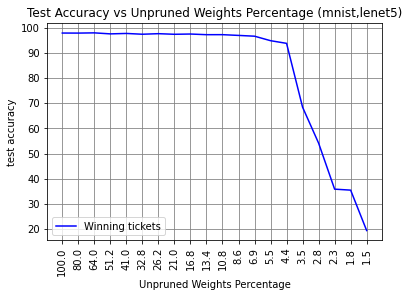

In [ ]:
plt.plot(a, best_acc, c="blue", label="Winning tickets") 
plt.title(f"Test Accuracy vs Unpruned Weights Percentage ({args.dataset},{args.arch_type})") 
plt.xlabel("Unpruned Weights Percentage") 
plt.ylabel("test accuracy") 
plt.xticks(a, comp, rotation ="vertical") 
# plt.ylim(0,100)
plt.legend() 
plt.grid(color="gray") 
# checkdir(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/")
# plt.savefig(f"{os.getcwd()}/plots/lt/{args.arch_type}/{args.dataset}/{args.prune_type}_AccuracyVsWeights.png", dpi=1200) 
plt.show()
plt.close()

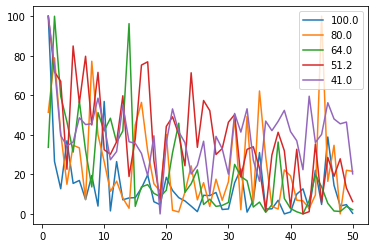

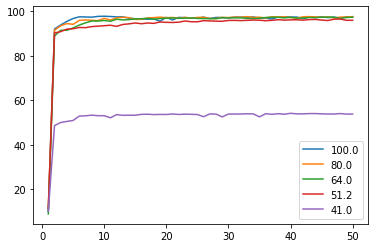

In [ ]:
#Plot Losses 
# levels=np.arange(1,(args.end_iter)+1)
for i in range(0,len(Iters),4):
  levels=np.arange(1,(Iters[i])+1)
  plt.plot(levels,Loss[i])
plt.legend(Comps)
plt.show()
#Plot Accuracies
for i in range(0,len(Iters),4):
  levels=np.arange(1,(Iters[i])+1)
  plt.plot(levels,Accuracies[i])
plt.legend(Comps)
plt.show()

In [ ]:
for i in range(len(Iters)):
  # levels=np.arange(1,(Iters[i])+1)
  print(Loss[i])

[100.          26.5447813   12.7284705   36.99155367  15.44061913
  16.92130528   7.26804854  19.42420328   3.96943376  56.89369928
   1.53124596  26.46326882   7.1401097    8.07487383   8.24543963
  13.06011876  19.7319245    6.16519959   4.67541762  18.49651007
  11.85877311   8.22676173   6.5606802    3.93336168   1.15781595
   9.42187189   9.27766433  10.85007813   2.23315346   2.49671637
  15.73138224  22.75917283   0.91196805   6.77885044  31.03714786
   2.5204476    2.56312107   6.89229582   0.           0.9729115
  10.01589519  12.69331094   2.58625634  22.07080058   4.79235808
  38.92304843  14.45198736   4.01564188   4.69567989   0.31561184]
[ 50.97176889  11.77107492  22.01389003   9.69934069   7.60545269
   2.33988952  15.79493143  12.83044172  29.62907346  15.85491029
  27.42740796  27.17651334  38.75034537  23.84341266  25.19443147
   7.27422426   3.98206724   4.13428985  54.34767352  15.94688193
  35.23825896  16.51388883   6.42705893  49.85300275  11.03908203
  33.50338

In [ ]:
for i in range(len(Iters)):
  # levels=np.arange(1,(Iters[i])+1)
  print(Accuracies[i])

[10.07 92.07 93.88 95.51 96.79 97.56 97.49 97.39 97.75 97.81 97.69 97.52
 97.54 96.98 96.67 96.5  96.48 96.55 95.58 97.31 96.14 97.3  97.19 96.99
 96.91 97.42 96.79 97.28 97.23 97.05 97.45 97.44 97.31 97.49 96.99 96.97
 96.57 97.43 97.56 97.45 97.44 96.75 97.42 97.22 97.57 97.2  97.42 96.83
 97.58 97.53]
[10.07 94.26 96.7  96.82 97.77 97.61 97.13 97.66 97.57 97.79 96.96 97.58
 96.3  97.01 96.87 97.17 96.78 97.02 97.12 97.32 97.42 97.17 97.5  97.16
 97.51 95.68 96.97 97.45 96.45 97.34 97.18 97.06 97.44 97.35 96.89 97.09
 97.22 97.55 97.39 96.84 97.16 97.38 97.62 97.43 97.01 97.4  97.51 97.37
 97.24 97.24]
[10.07 94.03 96.78 97.12 97.12 97.11 96.9  96.57 96.31 96.74 97.12 96.29
 97.17 97.13 96.81 96.92 97.29 96.78 97.5  97.27 97.6  97.47 97.57 97.55
 97.24 97.63 97.71 97.47 97.58 97.39 97.49 97.88 97.68 97.64 97.5  97.7
 97.54 96.72 97.74 97.45 97.3  97.11 97.44 97.58 97.73 96.9  97.48 97.6
 97.53 96.61]
[11.31 92.82 95.07 95.2  95.96 96.31 95.14 96.07 95.6  95.72 96.42 95.19
 96.58 96.4

In [ ]:
print(Comps)

[100.0, 80.0, 64.0, 51.2, 41.0, 32.8, 26.2, 21.0, 16.8, 13.4, 10.8, 8.6, 6.9, 5.5, 4.4, 3.5, 2.8, 2.3, 1.8, 1.5]


In [ ]:
Loss=[[100.          26.5447813   12.7284705   36.99155367  15.44061913
  16.92130528   7.26804854  19.42420328   3.96943376  56.89369928
   1.53124596  26.46326882   7.1401097    8.07487383   8.24543963
  13.06011876  19.7319245    6.16519959   4.67541762  18.49651007
  11.85877311   8.22676173   6.5606802    3.93336168   1.15781595
   9.42187189   9.27766433  10.85007813   2.23315346   2.49671637
  15.73138224  22.75917283   0.91196805   6.77885044  31.03714786
   2.5204476    2.56312107   6.89229582   0.           0.9729115
  10.01589519  12.69331094   2.58625634  22.07080058   4.79235808
  38.92304843  14.45198736   4.01564188   4.69567989   0.31561184]
[ 50.97176889  11.77107492  22.01389003   9.69934069   7.60545269
   2.33988952  15.79493143  12.83044172  29.62907346  15.85491029
  27.42740796  27.17651334  38.75034537  23.84341266  25.19443147
   7.27422426   3.98206724   4.13428985  54.34767352  15.94688193
  35.23825896  16.51388883   6.42705893  49.85300275  11.03908203
  33.50338032   0.         100.           7.02199833  35.18517465
  15.46687087  39.22661148   0.96185573  31.35575119   3.13192853
   3.94027988  14.25962236  12.03133923  39.20480165  16.11433088
   2.37684229  37.45036551  16.1136844    2.42021815   7.59410949
  63.61644485  28.71935005   4.58360048   3.64414179   2.15362085]
[ 42.63400431  17.40676401   8.95896378  30.75511364  30.27718067
  20.90343134  31.65128191  20.39542027  54.52315351  64.39973024
  42.6139652   15.24713509  47.52352384  17.81414042  66.88060082
   8.09984959 100.          13.83219498  14.25229159  14.4370598
  28.77122232   4.0908191   95.39956124  12.14362698  27.77285536
  15.89793987  44.79995738  51.90342748  35.36558556   4.01861496
   4.67519745  17.40753534  41.0504794    7.18258138  92.45211396
   9.97582815   7.26358687  14.77083805   6.20464406  66.1443957
  14.43446796  23.60461944  10.42159926  14.65210914  32.80558051
   0.          53.97421712  17.36487111  23.84718126   6.36794124]
[ 48.49870391  51.45098288  71.58938788  47.4040867    8.7238118
  42.49191566  36.64448702  50.87508323  31.94604303  74.74450484
  19.35876608  23.74434381  36.0936997   38.4668198   28.74857299
   9.63591664  26.19990558  31.63482304  28.02979595  36.03622587
   6.85150931  33.17068418  19.18591394  16.07400863   6.89720912
   0.           6.81193822  24.64735939   5.31464582   7.12963426
   7.55438345  47.94113698  38.06041027  59.73022521  45.0105472
  18.19902575  10.76503482   2.47476729  24.69702278   5.20570535
   6.0994608   55.07213654   7.82319895  13.5186019   19.41360586
  12.72283744   8.50980204  56.6995918  100.          28.62451455]
[ 51.41146109  78.95877857  40.92620818  14.9899361   34.72156341
  33.41688449   7.26576578  77.23271551  40.0054444   26.45888641
  11.41558272  16.5605855    7.99749273   2.87319503  45.09132925
  56.39168173  31.77339325  15.2518474   11.42924637  40.12922306
   1.85239046   0.98969532  11.04236276  24.304812     7.12609808
  15.7976114    3.78736985  17.5592858    6.89647196  16.26433309
  48.91273286   2.10903229  49.39617451   5.03450166  62.19681725
  28.83084118   3.80601773   2.46144643  22.24019268  19.27070492
   6.94618249   6.62037676   2.78028981   9.55287313 100.
  16.4590357   34.71962043   0.          22.08110644  21.54284953]
[ 25.077637    91.2514487   49.20519224 100.          80.35229611
  65.37793091  21.87069971  77.39299112  26.42689475  23.60320599
  17.45336022  10.19355598   9.5772729    3.24366292   0.13309612
  23.79788265  30.80139296   6.54228757  33.90359263   3.23225579
  43.60111679  22.66372328  28.72962352  23.06723879   6.22691148
   1.49734306  22.62272161  48.22781502  18.91974598   2.65856447
  11.2788771    5.84298483  27.8403353    5.55252169  16.90698306
  10.74988145   9.122291    18.17480257  25.52457453   3.38170472
   0.9972521   31.11685598   0.           5.81329292   8.92965217
  17.59286606  24.89894475   1.09246763  17.00394495   0.2171273 ]
[100.          43.72658071  22.70962772  25.94371273  28.41560992
  30.20280988  17.11426058  11.77938072  21.24379093  13.94221303
  32.59408189  37.16190266   8.30406732  18.58056124  19.64985986
   8.39518206  29.79680215   0.396347     9.0508829   16.75150667
   9.89987158   6.02715356   2.8988079   10.38219819  10.25409758
  46.83466706  16.7017498   22.29972701   8.78219886   1.12630806
  22.07488453  17.85284023  19.05414255   5.06463073   3.08607173
   0.45630683   1.39930376   5.86480292   0.85323493  10.37419609
  12.23997994   3.06026555   1.40183831  80.28554286  19.16957959
   1.34800487   5.85215452   0.           6.19181155   1.91809391]
[ 63.01495957 100.          77.36191826  58.6058146   61.13709136
  58.05668336  55.67533916  41.20717602   5.54099783  41.92534739
   9.35755396  89.26849685   9.65880744  29.10171673   0.
  14.34339576  39.16129559  16.78204709  54.65448592  56.12373071
  26.899694    23.02035911  66.1679087    2.40500255  24.43592783
  15.91250919  42.75588587   0.70758996   5.91610624  14.65579828
   5.1463758   95.01045038  36.67540709   2.32458578   9.34555611
  16.99496922  23.13640399   1.77763635   0.83901818   5.02837299
  24.9464835   24.73401525   0.73565865  28.80738942   8.35196252
  52.04171052  30.01181371  10.92951306  30.976608    22.29474539]
[ 33.68169712 100.          59.5486913   46.62142358  31.26620129
  57.08930711  32.07098313  13.6516072   51.25612067  42.03079059
  48.41223483  36.22813908  41.97930684  96.26691713   3.83357296
  13.66371124  14.81930598  10.40934941   8.730507    11.95048829
  30.92625583  45.89967974  10.90231219  15.26057812  22.31001374
   4.75069709   7.43131967   3.81163038   4.29689432   5.78328619
  25.04531784  18.94022328  16.74871146   3.47186944   5.97212597
   0.80260759   4.62601468  36.39749031   7.83166236   2.72540505
   1.0778323    0.           6.75715644  19.68822185  13.71539949
   5.3460546    1.47453666   1.24413355   3.83017908   2.10790205]
[ 53.36137914  48.63703591  37.70368531  66.67304266  36.68207185
  50.64755874  65.3300611   19.36305677  26.20376756  49.60008996
  22.31814032  58.07100519  38.10068543 100.           9.4473319
   7.821529    41.61680954   9.35218857  31.44465994  53.54120402
  13.56650596  44.62233256  15.99193595  21.78001164  14.2335646
  13.93230601  19.18550915   6.77512662   8.50957151   1.56052208
  29.6288661   12.74747293  18.21992803  12.57468884  33.91782218
  30.04221826   9.59349675  41.17576326  13.46307955  21.7718883
   5.35870404  16.75103473  37.37514216   5.06052824  17.21451366
  16.09557479   1.55590511   0.           3.67517447   6.58755398]
[ 84.12008079 100.          87.9052994   43.55011804  46.39590551
  36.03956051  72.61942581  20.93400014  71.21065932   9.62760901
  15.39161208  29.82861293  60.8184771   22.72077237  34.20125172
  58.6977932   21.71106093  13.17955676  36.2756223    2.9059943
   1.65409179  16.99951239  16.89476068   8.21038882  37.0497789
   3.79314564  13.65099003  12.42092692  11.15677936  10.01581582
   8.78983529   0.           6.56898516   5.45623027  12.89436509
  19.55338299   3.90500952  16.7148034   19.36579715  21.80937462
  14.58775428  14.75904078   4.63578934   1.58676354   0.52371424
  26.93578675   2.11290013   9.84382281   0.47746833   1.37402661]
[100.          66.76802259  78.868915    45.1106289   41.94211946
  36.56854146  78.14635845  56.48377232  24.5964079   24.51735431
  73.2456771   15.33455709  49.11343061  25.48604838  53.91619757
  52.07427639  30.34658583  43.70176222  44.08371383  29.81482487
   3.52816534  10.66080148   4.6921769   16.60256812  91.73148949
  22.21194906   2.74974931  23.62721722  37.49114695  13.97869594
   3.39037737   9.30747054  35.91807545  19.87240117  18.27271375
  18.40526529  27.22454424  46.38815519  53.53795484  54.64115127
   9.40664636  14.34218278   0.           5.22143175   9.73188775
   2.60522878  12.48858387  61.95398232  11.28866324  18.51611465]
[100.          71.80243203  67.08098537  22.59418924  84.95212077
  56.17530906  79.74501463  45.0140663   71.60883898  32.46381446
  30.17837962  36.4972248   59.76774868  18.93635589  37.93090183
  75.30142054  76.94485181  26.98070528   6.92695561  44.28438288
  49.11291613  40.28662785  24.35977602  71.39920958  33.68311443
  57.37908447  52.24669677  30.05539815  33.07939174  46.39655931
  50.26506646  18.69598944  32.67199584  33.97619614  23.23045275
   1.52122165  29.78327938  41.29721799  31.96402018   3.33384867
  32.69628756   0.           1.14203398  35.40174265   5.87183274
  28.54253795  19.03530363  27.88389885  13.054722     6.24751584]
[ 67.40581567  36.82551904  42.61056974  22.24536844  37.76227209
  56.6077495   56.64698422  68.71513718  32.09048144 100.
  86.73962526  35.61074003  45.59644755  25.47810149  41.69768928
  17.65927442  29.38804565  14.66078888  14.72492996  34.44974391
  15.48277075  28.7498529   38.79929281  33.36905122  29.33405325
   8.56758213  12.16036176  53.55033288  35.26141912   4.73315898
  10.64627375  42.08132684  20.14723462  25.4143279   23.16152189
  40.39976316  40.63075484  18.71814486  57.22557962   3.32987883
   6.17365098   9.71112285   0.          12.00157859   7.72777738
  45.97294154   5.25248329  31.00486723   3.4554272   57.23906999]
[ 55.73170155  11.68844765  73.26520166  89.20741505  23.01411729
  38.25111062  59.2820285   35.26957752  46.08140814  46.27869268
  83.38082611   4.81790314  69.13425926  30.64454861  25.91489369
  32.06556692   0.          33.19570502  74.33317967  52.71048837
  10.78008693  59.74687091  39.97564391  30.87725788  19.56169969
  33.90760163  50.60498705   5.38962139  58.37570247  31.42984715
  31.04794927  55.0189845   76.58428154 100.          17.06029469
  25.89607465  21.79295424  11.16722832   4.91760287  33.76230373
  25.47463527   5.8477982   33.84486176  17.75976438   5.83599847
  67.21683169  50.71059393  61.37601451  21.77206769  13.22580419]
[ 94.99682724  53.6387967   25.22159184  34.45594095  17.67055561
   0.           9.22551068   7.03953424  57.69627685  71.3276377
  59.83074896  93.65867221  40.93448395  62.4311642   34.40705024
  30.29145189  51.42230472  91.69169144  31.48140851  58.25309827
  78.70435923  94.00149575 100.          44.96156827  55.28769356
  54.55396378  85.15444168  38.71225597  32.94326174  41.08973516
  70.51378342  75.61964563  86.78969183  74.42342429  81.1396773
  59.58774187  89.09225381  54.64168974  61.2227127   98.55528496
  63.07020501  60.4212482   87.43300222  79.59556478   4.86876071
  37.60519708  50.60200617  67.78150989  65.71706693  62.57208038]
[100.          74.47001662  39.64544467  34.36726605  36.37711184
  48.63110066  45.20741722  45.63789254  58.55099685  44.76799667
  27.41233147  31.58175093  55.08815886  36.5097262   35.7030808
  30.59413578  19.34721671  39.51620393   0.          36.10049454
  53.12506342  41.55765962  36.04169113  20.16456572  24.55151282
  36.77631462   9.76545035  39.21833276  32.97191181  20.12509424
  50.81792917  41.38323268  53.18390772  27.26987223  16.50875092
  46.94949894  42.1214547   46.79845228  52.37978743  41.64789914
  37.00514903  22.36967318  59.54031926  36.14276716  40.22647594
  56.24960801  48.05155174  45.5823912   46.47189502  20.25308775]
[100.          58.25458872  51.83869222  51.03115704  54.78708381
  43.08549724  41.82057123  38.45231703  63.18063158  31.92407752
  50.88114776  34.2517236   51.29482087  44.75652628  42.67129492
  23.56754024  47.73350695  56.68550248  52.53485078  29.61000694
  16.12817757  45.50557176  34.37400664  29.87146187  37.15685766
  37.38860756  36.77180815  39.26797451  28.90611725  35.58831214
  28.09735106  38.54124806  54.30924921  62.96906086  11.35130415
  27.3310831    0.          27.62499268  19.72863035  24.67138948
  47.76693949  28.27115198  24.83766635  28.36982746  19.2141419
  39.64975669  32.36173784  26.50761396  49.77406571  14.96128279]
[ 94.66413416  52.33828179  80.48584535  40.66437858  49.79503277
  71.40441814  93.30040682  45.22669061  50.85129209  24.05576246
  19.58339801  58.86208396  26.58316804  49.19403709  17.34245817
  37.48450336  57.87532022  22.48320447   6.62055945  31.48566674
  55.60849437  79.61601576  50.87328029  65.52657397  69.73368132
  57.83434741  53.37535014  43.07191519   0.          60.53710837
  27.99073423   0.45031113  66.27252215  43.19510876  90.56628
  39.65461779  59.26374131  58.79614227  50.3985735   34.19168351
  36.05283956  57.08745918  47.29649388  29.82689848  68.69553534
  56.54055127 100.          17.4501293   17.88500971  57.96214956]
[100.          73.15370388  54.13719512  23.20278995  18.51046344
  10.88943957  16.9236447    8.02708696  12.08970394  21.9545331
  17.24659458   3.28988535   0.          13.84508713  20.02905191
  23.65272254  10.48410554  20.31713246   5.92316126   6.25264757
  27.38152911   7.42500642   5.82498912  13.4175041    9.58755886
  23.37791597  10.81087672  13.14566407  18.68000836  11.02006759
  18.77528938  16.93385159  18.6938857    9.88539377  12.7789704
  22.71999924  15.16396255  17.56625111  17.89475695  13.74998209
  15.36822597   7.33425061   8.80286054   8.32917055   9.96440914
   2.65482098   9.57043845  17.33496208  10.25256511  21.05750876]]

SyntaxError: ignored

In [ ]:
[10.07 92.07 93.88 95.51 96.79 97.56 97.49 97.39 97.75 97.81 97.69 97.52
 97.54 96.98 96.67 96.5  96.48 96.55 95.58 97.31 96.14 97.3  97.19 96.99
 96.91 97.42 96.79 97.28 97.23 97.05 97.45 97.44 97.31 97.49 96.99 96.97
 96.57 97.43 97.56 97.45 97.44 96.75 97.42 97.22 97.57 97.2  97.42 96.83
 97.58 97.53]
[10.07 94.26 96.7  96.82 97.77 97.61 97.13 97.66 97.57 97.79 96.96 97.58
 96.3  97.01 96.87 97.17 96.78 97.02 97.12 97.32 97.42 97.17 97.5  97.16
 97.51 95.68 96.97 97.45 96.45 97.34 97.18 97.06 97.44 97.35 96.89 97.09
 97.22 97.55 97.39 96.84 97.16 97.38 97.62 97.43 97.01 97.4  97.51 97.37
 97.24 97.24]
[10.07 94.03 96.78 97.12 97.12 97.11 96.9  96.57 96.31 96.74 97.12 96.29
 97.17 97.13 96.81 96.92 97.29 96.78 97.5  97.27 97.6  97.47 97.57 97.55
 97.24 97.63 97.71 97.47 97.58 97.39 97.49 97.88 97.68 97.64 97.5  97.7
 97.54 96.72 97.74 97.45 97.3  97.11 97.44 97.58 97.73 96.9  97.48 97.6
 97.53 96.61]
[11.31 92.82 95.07 95.2  95.96 96.31 95.14 96.07 95.6  95.72 96.42 95.19
 96.58 96.47 96.83 96.97 96.69 96.67 97.06 96.62 96.91 96.66 96.29 96.39
 97.22 96.89 96.4  97.04 97.16 97.23 97.07 97.32 96.98 97.03 97.39 96.7
 96.91 97.29 97.36 97.09 97.48 97.14 97.15 97.4  97.03 97.32 96.72 97.35
 96.49 96.62]
[11.31 91.57 93.52 94.51 94.17 95.96 96.14 96.   95.85 96.86 96.11 97.09
 97.32 97.19 96.39 96.42 97.07 97.19 97.41 97.15 97.27 96.89 97.32 96.88
 97.28 97.33 96.81 96.78 97.3  97.22 97.41 97.38 97.64 97.26 97.37 97.05
 97.59 97.49 97.53 97.23 96.95 97.56 97.64 97.52 97.39 97.45 97.09 97.42
 97.48 97.65]
[11.31 90.88 91.95 92.61 93.62 94.74 94.13 95.57 95.71 96.13 96.09 96.01
 96.03 96.33 96.79 96.83 96.21 96.87 96.25 96.56 96.94 96.62 96.6  96.75
 97.16 97.01 96.64 96.96 97.24 96.99 96.86 96.53 96.67 96.93 97.11 96.64
 96.8  97.34 97.02 96.54 97.11 97.25 96.97 97.27 97.14 97.03 97.16 96.83
 97.13 97.08]
[11.31 91.31 92.08 91.12 92.8  94.36 95.81 94.94 95.11 96.22 96.27 94.62
 96.33 96.35 96.3  95.73 96.37 96.43 96.92 97.08 96.69 97.09 96.85 96.62
 96.83 96.95 97.18 96.85 97.02 97.08 96.97 97.25 96.74 97.33 96.97 97.13
 97.12 97.35 97.22 97.56 97.18 97.11 96.92 97.16 97.26 97.11 97.06 97.29
 96.8  97.05]
[11.31 90.96 90.63 91.75 93.22 93.51 94.   94.76 95.18 95.41 95.75 95.95
 96.28 96.1  96.41 95.5  96.19 96.67 96.02 96.61 96.71 96.82 96.83 96.53
 96.87 96.88 96.85 96.81 96.24 96.8  97.12 96.9  96.98 96.66 96.96 97.09
 96.48 97.32 97.17 96.97 96.71 97.13 96.9  97.04 96.78 97.28 97.2  97.12
 97.15 97.19]
[ 8.88 88.91 91.52 91.48 92.55 93.86 94.84 95.66 95.64 95.9  95.55 96.47
 96.15 96.31 96.59 96.69 96.87 96.51 96.77 96.95 97.06 96.86 96.98 97.
 96.84 96.76 96.72 96.72 97.13 97.07 97.09 97.08 96.87 96.77 96.96 97.24
 97.34 97.34 97.07 97.33 96.98 97.   97.26 97.19 97.36 97.42 97.35 96.88
 97.22 97.42]
[11.31 90.62 91.62 91.89 91.7  92.99 92.85 93.56 94.29 94.17 95.06 95.2
 95.56 95.4  95.77 96.13 96.07 96.33 96.26 96.44 96.74 96.71 96.51 96.28
 96.67 96.43 96.95 96.78 96.54 96.76 96.69 96.76 96.74 96.07 95.95 96.48
 96.89 96.99 96.63 97.01 97.09 96.89 96.84 97.07 97.11 97.16 97.01 96.55
 96.87 96.67]
[10.24 90.52 91.74 91.21 91.66 92.7  93.36 93.25 94.19 94.9  94.75 95.2
 95.47 95.69 95.61 95.94 95.78 96.09 95.75 95.87 96.1  96.48 96.17 96.75
 96.47 96.7  96.08 96.57 96.41 96.73 96.92 96.36 96.69 96.81 96.65 96.51
 96.57 96.74 97.01 96.9  96.95 96.81 96.5  96.33 97.09 97.17 96.6  96.99
 96.59 96.65]
[10.24 90.43 89.64 91.61 91.7  92.54 92.74 93.17 92.93 93.98 94.25 94.07
 94.2  94.47 94.51 94.88 95.06 95.25 95.42 95.48 95.71 95.48 95.68 95.76
 95.99 96.07 96.02 95.95 96.27 95.97 96.13 96.31 96.45 96.25 96.21 96.48
 96.61 96.56 96.21 96.47 96.54 96.59 96.68 96.44 96.59 96.55 96.72 96.52
 96.57 96.87]
[11.31 90.29 90.88 92.03 92.18 92.76 92.67 93.15 93.35 93.55 93.77 93.26
 94.12 94.39 94.78 94.44 94.77 94.61 95.23 95.06 95.01 95.14 95.67 95.34
 95.31 95.82 95.71 95.59 95.55 95.91 95.95 95.85 95.97 96.1  96.03 95.8
 95.96 96.26 96.07 96.17 96.23 96.05 96.31 96.37 96.11 95.88 96.48 96.56
 95.98 95.99]
[10.24 89.52 90.71 91.01 91.36 91.46 91.97 91.64 92.15 92.44 92.38 91.82
 92.71 92.42 92.61 92.69 92.64 92.49 93.03 92.62 92.92 92.4  92.37 93.08
 93.43 92.87 93.63 93.13 93.59 93.59 93.48 93.32 93.86 93.64 94.01 93.67
 93.92 94.15 93.96 94.16 94.04 94.06 94.35 94.51 94.24 93.8  94.56 94.35
 94.65 94.78]
[11.31 88.49 89.85 90.2  90.56 90.82 91.05 91.14 91.49 91.74 91.37 91.91
 91.91 91.98 91.72 92.31 91.42 92.29 91.8  92.34 92.22 92.12 92.31 92.18
 92.21 92.54 92.15 92.62 92.32 92.78 92.76 92.76 92.58 92.85 92.94 92.92
 92.9  92.96 93.16 93.16 93.25 93.38 93.47 93.07 93.06 93.36 93.64 93.59
 93.25 93.72]
[10.24 56.97 65.22 68.27 68.39 67.9  66.51 66.93 66.68 66.82 65.26 65.86
 59.6  58.85 58.22 58.4  58.68 58.45 59.1  58.76 58.62 58.57 58.87 57.46
 58.79 58.85 58.98 59.05 59.1  57.72 57.9  58.86 57.64 57.71 57.87 58.89
 59.18 57.91 57.56 58.82 57.86 57.68 58.96 57.98 59.2  58.99 59.2  59.1
 58.8  57.83]
[10.07 48.61 50.   50.49 50.94 52.91 53.01 53.3  53.07 53.07 52.13 53.56
 53.23 53.29 53.27 53.67 53.73 53.57 53.64 53.6  53.85 53.63 53.76 53.69
 53.59 52.61 53.86 53.79 52.52 53.82 53.8  53.85 53.92 53.88 52.55 53.96
 53.68 53.98 53.73 54.14 53.91 53.88 54.02 54.03 53.89 53.83 53.83 54.02
 53.79 53.8 ]
[10.07 33.89 34.71 34.95 35.44 35.55 35.25 35.66 35.63 35.59 35.86 35.71
 35.66 35.84 35.75 35.76 35.68 35.66 35.87 35.68 35.66 35.85 35.75 35.7
 35.65 35.7  35.7  35.76 35.72 35.71 35.7  35.75 35.75 35.62 35.88 35.82
 35.7  35.74 35.54 35.64 35.69 35.8  35.85 35.58 35.62 35.73 35.71 35.67
 35.82 35.82]
[11.31 33.3  34.33 34.96 35.02 34.89 35.16 35.22 35.22 35.19 34.94 35.3
 35.26 35.32 35.19 35.33 34.94 35.29 35.24 35.34 35.41 35.21 35.46 35.48
 35.43 35.34 35.45 35.41 35.44 35.1  35.4  35.38 35.47 35.34 35.3  35.29
 35.12 35.22 35.35 35.37 35.46 35.49 35.26 35.43 35.22 35.42 35.37 35.44
 35.44 35.25]
[11.31 18.98 19.07 19.46 19.29 19.28 19.18 19.2  18.97 19.21 19.09 19.19
 19.12 19.18 19.26 19.22 19.1  19.14 19.19 19.03 19.14 19.27 19.2  19.01
 18.99 19.24 18.98 19.17 19.18 19.18 19.19 19.17 19.15 19.15 19.07 19.1
 19.02 19.13 19.2  19.26 18.97 19.19 18.99 19.2  19.16 19.02 19.32 19.12
 19.16 19.3 ]